In [1]:
import os
import sys
from datetime import datetime
from os.path import abspath
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import quantstats as qs
from hurst import compute_Hc

yf.pdr_override()

# Zipline imports
from zipline.utils.run_algo import load_extensions
from zipline.data import bundles
from zipline.data.data_portal import DataPortal
from zipline.utils.calendar_utils import get_calendar

from zipline.api import set_max_leverage, schedule_function, set_benchmark,set_commission
from zipline.finance.commission import PerContract, PerDollar, PerShare, PerTrade
from zipline.finance.commission import CommissionModel
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage
from zipline.finance.commission import PerShare, PerTrade, PerDollar
from zipline.api import set_slippage, set_commission
from zipline.data.bundles import register, unregister, ingest
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.calendar_utils import register_calendar, get_calendar
from zipline.api import (order, 
                         order_target,
                         order_value,
                         record, 
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, date_rules, time_rules, symbol # type: ignore

# Ignore Warnings  
import warnings
warnings.filterwarnings('ignore', category=Warning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
%matplotlib inline
%load_ext autoreload
%autoreload 2

ROOT_DIR = abspath('../')
sys.path.append(ROOT_DIR)

In [8]:
bundle = 'sp500bundle'
calendar_name = 'NYSE'
calendar = get_calendar(calendar_name)
bundle_data = bundles.load(bundle)
sids = bundle_data.asset_finder.sids
assets = bundle_data.asset_finder.retrieve_all(sids)
sp500_tickers = [coin.symbol for coin in assets]

In [2]:
ROOT_DIR = abspath('../')
sys.path.append(ROOT_DIR)
TICKER_FILE_PATH = f"{ROOT_DIR}/data/sp500_tickers.csv" 
PARQUET_FILE_PATH = f"{ROOT_DIR}/data/sp500_stock_data.parquet"

START_DATE = datetime(2018, 1, 1)
END_DATE = datetime(2022, 12, 31)

def calculate_years() -> int:
    return int((END_DATE - START_DATE).days / 365)

YEARS = calculate_years()

In [13]:
sp500_tickers = [coin.symbol for coin in assets]

In [3]:
def load_tickers():
    sp500_df = pd.read_csv(TICKER_FILE_PATH)
    sp500_stock_data = pd.read_parquet(PARQUET_FILE_PATH) 
    return sp500_df['Ticker'].tolist(), sp500_stock_data

def is_not_null(close_data: pd.Series) -> bool:
    years = calculate_years()
    return len(close_data) >= 251.5 * years

def calculate_hurst_exponent(close_data: pd.Series) -> float: 
    H, c, data = compute_Hc(close_data, kind="price", simplified=True)
    return H

def hurst_filter(threshold: float = 0.5): # threshold < 0.5 --> mean reverting time series
    sp500_tickers, sp500_stock_data = load_tickers()
    filtered_tickers = []
    for ticker in sp500_tickers:
        if ticker in sp500_stock_data:
            close_data = sp500_stock_data[ticker][START_DATE : END_DATE][
                "close"
            ].dropna()
            if is_not_null(close_data):
                hurst_exponent = calculate_hurst_exponent(close_data)
                if hurst_exponent <= threshold:
                    filtered_tickers.append((ticker, hurst_exponent))

    filtered_tickers.sort(key=lambda x: x[1])
    top_n_tickers = [ticker for ticker, _ in filtered_tickers] # Top 10 stocks from the hurst filter
    # top_n_tickers = pd.DataFrame(top_n_tickers)
    return top_n_tickers

def calculate_atr(high_prices, low_prices, close_prices, period=14):
    high_low_diff = high_prices - low_prices
    high_close_diff = np.abs(high_prices - np.roll(close_prices, 1))
    low_close_diff = np.abs(low_prices - np.roll(close_prices, 1))
    true_range = np.maximum(high_low_diff, high_close_diff, low_close_diff)
    atr = np.mean(true_range[:period])
    for i in range(period, len(true_range)):
        atr = ((period - 1) * atr + true_range[i]) / period
    return atr
    

In [4]:
hurst_filtered = hurst_filter()

In [5]:
START_DATE = pd.Timestamp('2018-01-01')
END_DATE = pd.Timestamp('2022-12-31') # Backtesting for 5 years

BASE_CAPITAL = 100_000

In [6]:
def plots(results):
    start = results.index[0]
    end = results.index[-1]
    benchmark = pdr.get_data_yahoo('^GSPC', start=start, end=end)['Adj Close'].pct_change()
    results.index = pd.to_datetime(results.index).tz_convert(None)
    results.index = benchmark.index  
    qs.reports.full(results['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4))
              

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-01-31   2018-01-31
End Period                 2022-12-30   2022-12-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       94.0%

Cumulative Return          36.04%       47.58%
CAGR﹪                     4.42%        5.62%

Sharpe                     0.4          0.72
Prob. Sharpe Ratio         80.77%       94.87%
Smart Sharpe               0.39         0.71
Sortino                    0.54         1.14
Smart Sortino              0.54         1.12
Sortino/√2                 0.38         0.8
Smart Sortino/√2           0.38         0.79
Omega                      1.16         1.16

Max Drawdown               -33.92%      -13.01%
Longest DD Days            361          317
Volatility (ann.)          22.0%        11.96%
R^2                        0.27         0.27
Information Ratio          -0.0         -0.0
Calmar                

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-09-17,2018-12-24,2019-07-30,317,-13.008356,-10.347167
2,2020-07-20,2020-09-23,2021-01-27,192,-12.480020,-11.345239
3,2020-02-20,2020-03-12,2020-03-27,37,-11.541786,-10.113806
4,2021-06-18,2021-11-30,2022-04-19,306,-11.216480,-10.463636
5,2022-04-21,2022-11-11,2022-12-30,254,-10.665781,-10.496221


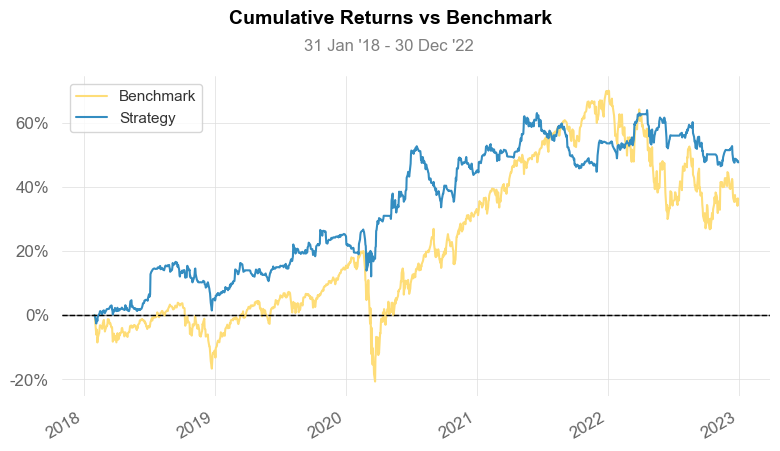

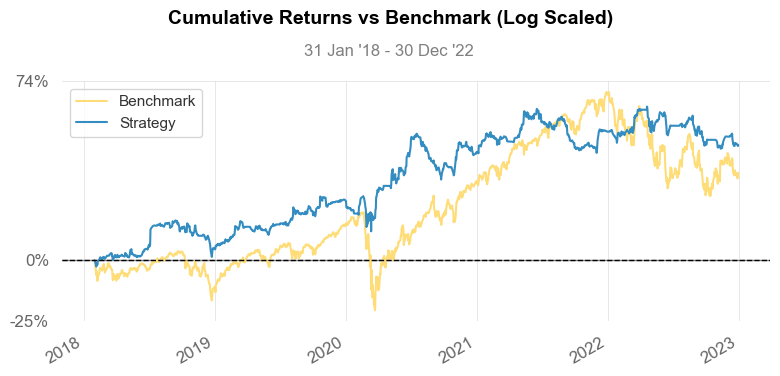

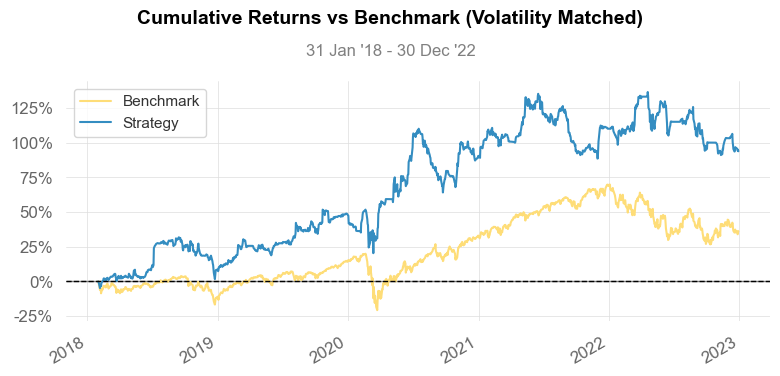

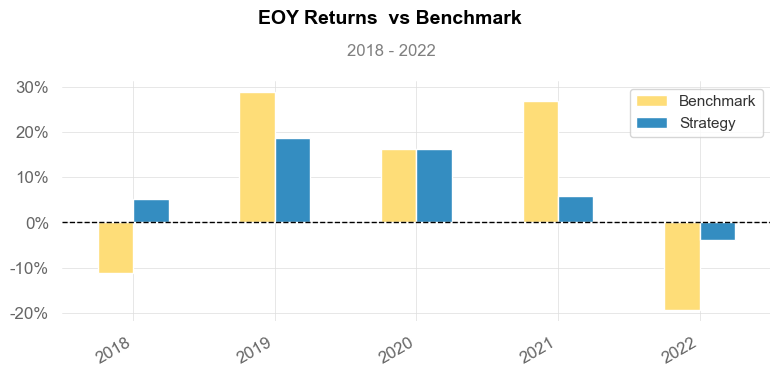

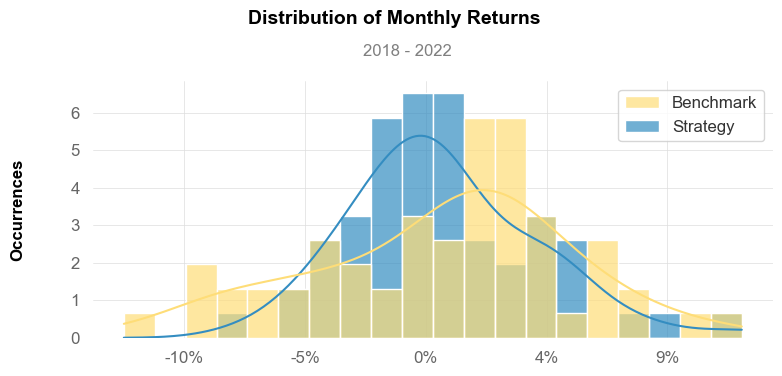

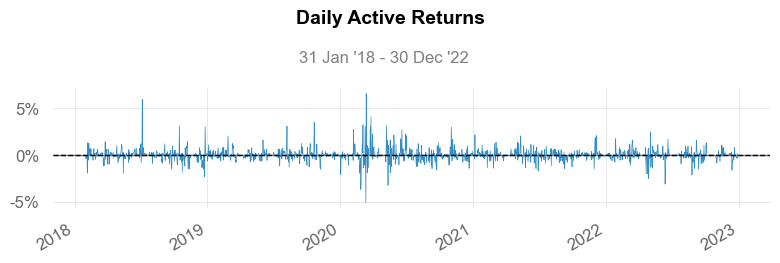

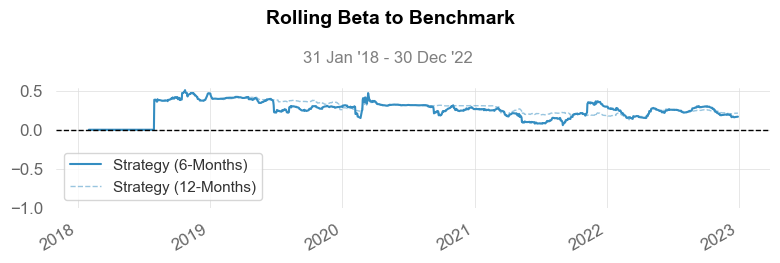

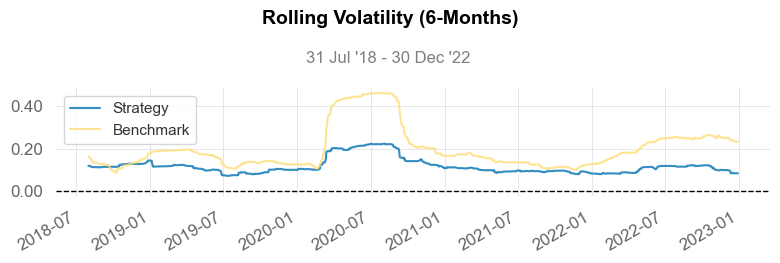

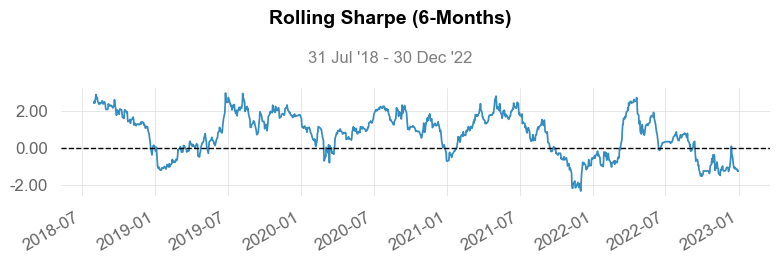

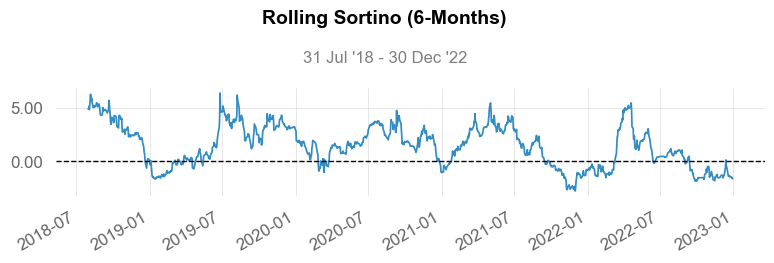

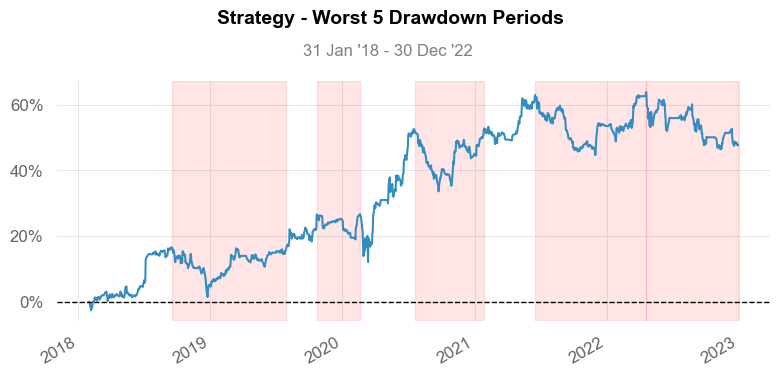

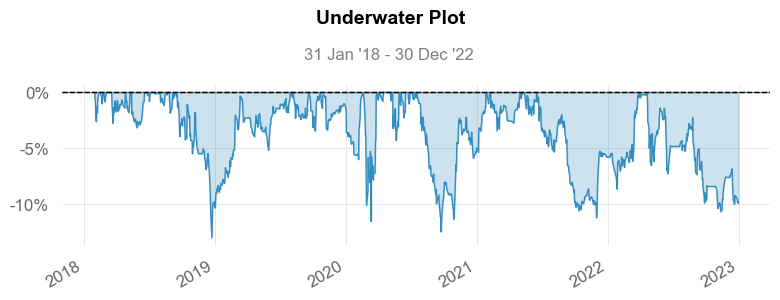

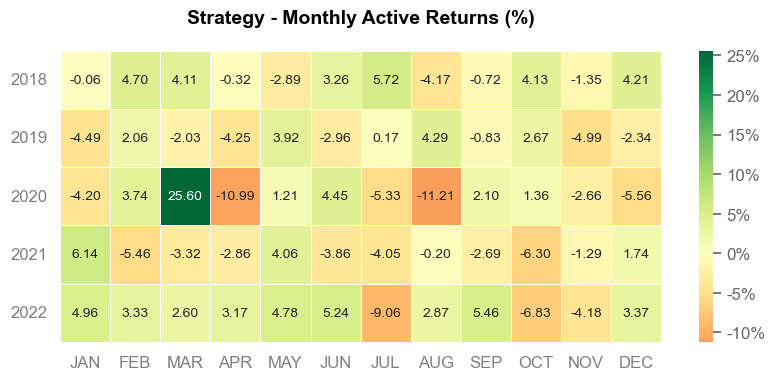

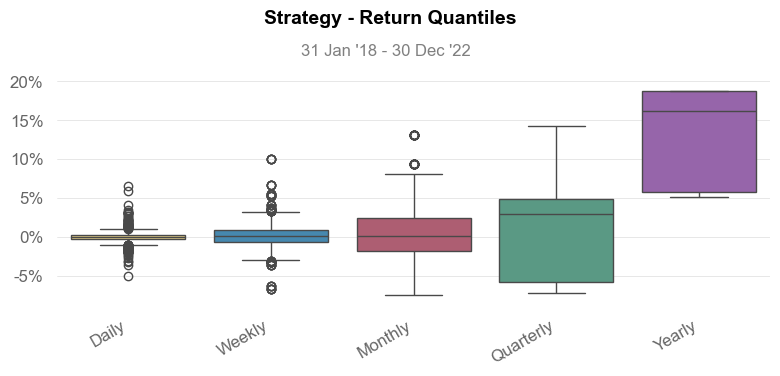

In [7]:
def initialize(context):
    context.idx = 0
    context.tickers = hurst_filtered 
    context.bollinger_window = 20
    context.bollinger_dev = 1.5
    context.stop_loss = 0.05 
    context.take_profit  = 0.05
    context.stops, context.profits = 0, 0
    context.buy_stocks = set()
    context.cash_pct = 0.25
    context.atr_window = 14
    context.atr_dev = 1.5
    context.buy_count, context.sell_count = 0, 0
    
    # set_commission(PerShare(cost=0.003))
    # set_slippage(VolumeShareSlippage(volume_limit=0.10, price_impact=0.15))

def handle_data(context, data):
    context.idx += 1
    if context.idx < context.bollinger_window:
        return

    for ticker in context.tickers:
        # Get historical price data using data.history
        prices = data.history(symbol(ticker), 'price', context.bollinger_window + 1, '1d')

        # Calculate Bollinger Bands
        sma = prices.mean()
        rolling_std = prices.std()
        upper_band = sma + (context.bollinger_dev * rolling_std)
        lower_band = sma - (context.bollinger_dev * rolling_std)

        current_price = data.current(symbol(ticker), 'price')
        cost_basis = context.portfolio.positions[symbol(ticker)].cost_basis
        amount = context.portfolio.positions[symbol(ticker)].amount

        # Generate signals based on Bollinger Bands, 
        if current_price < lower_band and ticker not in context.buy_stocks:        
            order_value(symbol(ticker), context.portfolio.cash * context.cash_pct)  # Buy Signal
            context.buy_count += 1
            context.buy_stocks.add(ticker)
        elif current_price > upper_band and ticker in context.buy_stocks:
            order_target_percent(symbol(ticker), 0)  # Sell Signal
            context.sell_count += 1
            context.buy_stocks.remove(ticker)
        
        # stop-loss, and take-profit
        high = data.history(symbol(ticker), 'high', context.atr_window + 1, '1d')
        low = data.history(symbol(ticker), 'low', context.atr_window + 1, '1d')
        close = data.history(symbol(ticker), 'close', context.atr_window + 1, '1d')
        atr = calculate_atr(high, low, close, context.atr_window)
        if amount > 0:
            if current_price >= cost_basis + (atr * context.atr_dev):
                order_target_percent(symbol(ticker), 0)
                context.profits += 1
            elif current_price < cost_basis - (atr * context.atr_dev):
                order_target_percent(symbol(ticker), 0)
                context.stops += 1
        elif amount < 0:
            if current_price >= cost_basis + (atr * context.atr_dev):
                order_target_percent(symbol(ticker), 0)
                context.stops += 1
            elif current_price <= cost_basis -  (atr * context.atr_dev):
                order_target_percent(symbol(ticker), 0)
                context.profits += 1
                
        # Record the values for later analysis
        record(
            price=current_price,
            mid=sma,
            upper=upper_band,
            lower=lower_band,
            buy_count = context.buy_count, 
            sell_count = context.sell_count, 
            profits = context.profits,
            stops = context.stops         
        )
        
# Run the algorithm
results = run_algorithm(
    start=START_DATE,
    end=END_DATE,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=BASE_CAPITAL,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='sp500bundle',
)
plots(results)